In [ ]:
%%capture
!pip install lightning

In [ ]:
%%capture
!pip install pytorch-lightning

## Аминокислотные последовательности антител

<img src="https://i0.wp.com/www.blopig.com/blog/wp-content/uploads/2013/07/Antibody1.png?ssl=1" style="background:white" width="600"/>

Как и любые белки́, [антитела](https://ru.wikipedia.org/wiki/%D0%90%D0%BD%D1%82%D0%B8%D1%82%D0%B5%D0%BB%D0%B0) состоят из [аминокислот](https://shorturl.at/Wc6V4), соединённых пептидными связями.

Каждой аминокислоте соответствует однобуквенный код (A - аланин, C - цистеин, D - аспартат, и т.д.), поэтому мы можем компактно записывать первичную структуру белков (то есть просто цепочку аминокислот) в виде строк.

Сегодня нам предстоит решить две задачи:
1. Обучить модель-классификатор, позволяющую по аминокислотной последовательности понять, из какого животного было получено антитело
2. Обучить модель-генератор новых антител с условием на биологический вид

#### Подготовим данные

В нашем наборе данных присутствуют антитела (точнее - небольшие фрагменты тяжелых цепей антител, VH-домены, непосредственно участвующие в связывании инородных молекул - антигенов), полученные из образцов пяти биологических видов: человек, макака-резус, мышь, кролик и верблюд.

In [ ]:
import pandas as pd

antibodies = pd.read_csv("antibodies.csv").sample(frac=1.0)
# antibodies.head(10)

Создадим словари для аминокислот, специальных токенов и биологических видов:

In [ ]:
SPECIAL_TOKENS = "_?\n"
AMINO_ACIDS = "ACDEFGHIKLMNPQRSTVWYX"
VOCAB = {char: i for i, char in enumerate(SPECIAL_TOKENS + AMINO_ACIDS)}
SPECIES = {name: i for i, name in enumerate(sorted(antibodies["species"].unique()))}
SPECIES

{'Camel': 0, 'Human': 1, 'Mouse': 2, 'Rabbit': 3, 'Rhesus': 4}

In [ ]:
import torch
from torch import Tensor, nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset, random_split


class AntibodiesDataset(Dataset):
    def __init__(self, df: pd.DataFrame) -> None:
        self.sequences = [
            [1] + [VOCAB[char] for char in s] + [2] for s in df["sequence"]
        ]
        self.labels = [SPECIES[label] for label in df["species"]]

    def __getitem__(self, index: int) -> tuple[list[int], int]:
        return self.sequences[index], self.labels[index]

    def __len__(self) -> int:
        return len(self.sequences)

    @staticmethod
    def collate_fn(batch: list[tuple[list[int], int]]) -> tuple[Tensor, Tensor]:
        encoded, lang_ids = zip(*batch)
        max_len = max(map(len, encoded))
        x = torch.zeros((len(encoded), max_len), dtype=int)
        for i, seq in enumerate(encoded):
            x[i, : len(seq)] = torch.tensor(seq)

        return x, torch.tensor(list(lang_ids))


labels = sorted(antibodies["species"].unique())
dataset = AntibodiesDataset(antibodies)
train_dataset, test_dataset = random_split(
    dataset, [4500, 500], torch.Generator().manual_seed(42)
)
print("Train size: ", len(train_dataset))
print("Test size: ", len(test_dataset))

Train size:  4500
Test size:  500


In [ ]:
train_loader = DataLoader(
    train_dataset, batch_size=32, shuffle=True, collate_fn=dataset.collate_fn
)
test_loader = DataLoader(
    test_dataset, batch_size=32, shuffle=False, collate_fn=dataset.collate_fn
)

#### Задание 1 (6 баллов). Классификация антител по биологическим видам

Мы начнём с нашей рекуррентной ячейки с последней практики:

In [ ]:
class RNNCell(nn.Module):
    """
    (x_{t}, h_{t-1}) -> h_{t}
    """

    def __init__(self, input_dim: int, hidden_dim: int) -> None:
        super().__init__()
        self.linear = nn.Linear(input_dim + hidden_dim, hidden_dim)

    def forward(self, x: Tensor, h: Tensor) -> Tensor:
        # x: B x input_dim
        # h: B x hidden_dim
        h = torch.cat([x, h], dim=1)
        h = self.linear(h)
        return F.tanh(h)

**1.1. (1 балл)** Реализуйте архитектуру модели, которая по входной последовательности будет давать вероятностное распределение над биологическими видами.
Она даже немного проще, чем модель для генерации: линейный блок-классификатор мы применяем только к последнему скрытому состоянию (когда вся последовательность обработана).

**1.2. (2 балла)** Обучите модель в течение 10-50 эпох, постройте графики точности классифкации для обучающей и тестовой выборок.

**1.3. (3 балла)** Реализуйте другой вид рекуррентной ячейки (GRU или LSTM, см. практику), обучите модель на его основе, выведите графики точности. Как изменилась точность модели и скорость обучения?


Указание: используйте небольшие модели, с размером скрытого слоя 64

In [ ]:
class RNN(nn.Module):
    def __init__(
        self, vocab_size: int, hidden_dim: int = 64, n_classes: int = 5
    ) -> None:
        super().__init__()
        self.embed = nn.Embedding(vocab_size, hidden_dim)
        self.init_h = nn.Parameter(torch.randn(1, hidden_dim))
        self.rnn = RNNCell(hidden_dim, hidden_dim)
        self.classifier = nn.Linear(hidden_dim, n_classes)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x: Tensor) -> Tensor:
        # x: B x T
        B, T = x.shape
        x = self.embed(x)  # B x T x hidden_dim
        h = self.init_h.expand((B, -1))  # B x hidden_dim

        for t in range(T):
            xt = x[:, t, :]
            h = self.rnn(xt, h)  # B x hidden_dim

        logits = self.classifier(h)
        probs = self.softmax(logits)
        return probs

In [ ]:
import torchmetrics
import pytorch_lightning as L
import torch
from torch import nn, optim

class Lit(L.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=5)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=5)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        probs = self(x)
        loss = nn.functional.cross_entropy(probs, y)
        self.train_acc(probs, y)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train_acc", self.train_acc, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        probs = self(x)
        loss = nn.functional.cross_entropy(probs, y)
        self.val_acc(probs, y)
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        self.log("val_acc", self.val_acc, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

In [ ]:
from lightning.pytorch.loggers import CSVLogger

model = RNN(vocab_size=len(VOCAB), hidden_dim=64, n_classes=5)

lit_module = Lit(model=model)

trainer = L.Trainer(
    accelerator="auto",
    max_epochs=20,
    log_every_n_steps=10,
    enable_progress_bar=True,
    logger=CSVLogger("logs"),
)

trainer.fit(lit_module, train_loader, test_loader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | RNN                | 10.2 K | train
1 | train_acc | MulticlassAccuracy | 0      | train
2 | val_acc   | MulticlassAccuracy | 0      | train
---------------------------------------------------------
10.2 K    Trainable params
0         Non-trainable params
10.2 K    Total params
0.041     Total estimated model params size (MB)
8         Modules in train mode
0   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


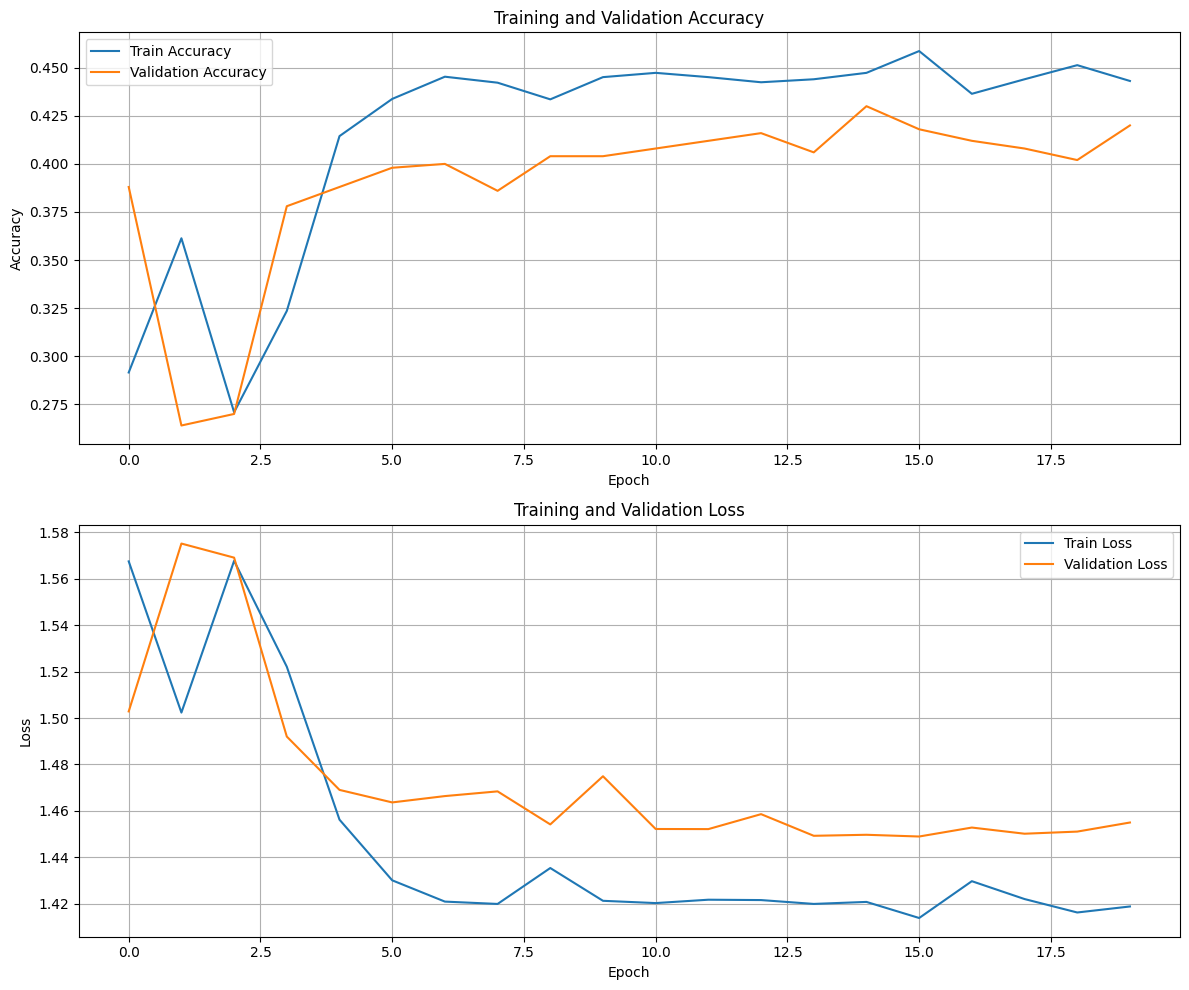

In [ ]:
import matplotlib.pyplot as plt

logs = pd.read_csv('logs/lightning_logs/version_0/metrics.csv')

train_acc = logs[logs['train_acc'].notna()][['epoch', 'train_acc']]
val_acc = logs[logs['val_acc'].notna()][['epoch', 'val_acc']]
train_loss = logs[logs['train_loss'].notna()][['epoch', 'train_loss']]
val_loss = logs[logs['val_loss'].notna()][['epoch', 'val_loss']]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

ax1.plot(train_acc['epoch'], train_acc['train_acc'], label='Train Accuracy')
ax1.plot(val_acc['epoch'], val_acc['val_acc'], label='Validation Accuracy')
ax1.set_title('Training and Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

ax2.plot(train_loss['epoch'], train_loss['train_loss'], label='Train Loss')
ax2.plot(val_loss['epoch'], val_loss['val_loss'], label='Validation Loss')
ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()

plt.show()

#### GRU

In [ ]:
class GRUCell(nn.Module):
    """
    (x_{t}, h_{t-1}) -> h_{t}
    """
    def __init__(self, input_dim: int, hidden_dim: int) -> None:
        super().__init__()
        self.linear_z = nn.Linear(input_dim + hidden_dim, hidden_dim)
        self.linear_r = nn.Linear(input_dim + hidden_dim, hidden_dim)
        self.linear = nn.Linear(input_dim + hidden_dim, hidden_dim)

    def forward(self, x: Tensor, h: Tensor) -> Tensor:
        # x: B x input_dim
        # h: B x hidden_dim
        hс = torch.cat([x, h], dim=1)
        zt = torch.sigmoid(self.linear_z(hс))
        rt = torch.sigmoid(self.linear_r(hс))
        h_tilde = torch.tanh(self.linear(torch.cat([x, rt * h], dim=1)))
        h = (1 - zt) * h + zt * h_tilde
        return h

In [ ]:
class RNN_GRU(nn.Module):
    def __init__(
        self, vocab_size: int, hidden_dim: int = 64, n_classes: int = 5
    ) -> None:
        super().__init__()
        self.embed = nn.Embedding(vocab_size, hidden_dim)
        self.init_h = nn.Parameter(torch.randn(1, hidden_dim))
        self.rnn = GRUCell(hidden_dim, hidden_dim)
        self.classifier = nn.Linear(hidden_dim, n_classes)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x: Tensor) -> Tensor:
        # x: B x T
        B, T = x.shape
        x = self.embed(x)  # B x T x hidden_dim
        h = self.init_h.expand((B, -1))  # B x hidden_dim

        for t in range(T):
            xt = x[:, t, :]
            h = self.rnn(xt, h)  # B x hidden_dim

        logits = self.classifier(h)
        probs = self.softmax(logits)
        return probs

In [ ]:
from lightning.pytorch.loggers import TensorBoardLogger, CSVLogger

model = RNN_GRU(vocab_size=len(VOCAB), hidden_dim=64, n_classes=5)

lit_module = Lit(model=model)

trainer = L.Trainer(
    accelerator="auto",
    max_epochs=10,
    log_every_n_steps=10,
    enable_progress_bar=True,
    logger=CSVLogger("logs"),
)

trainer.fit(lit_module, train_loader, test_loader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | RNN_GRU            | 26.7 K | train
1 | train_acc | MulticlassAccuracy | 0      | train
2 | val_acc   | MulticlassAccuracy | 0      | train
---------------------------------------------------------
26.7 K    Trainable params
0         Non-trainable params
26.7 K    Total params
0.107     Total estimated model params size (MB)
10        Modules in train mode
0   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


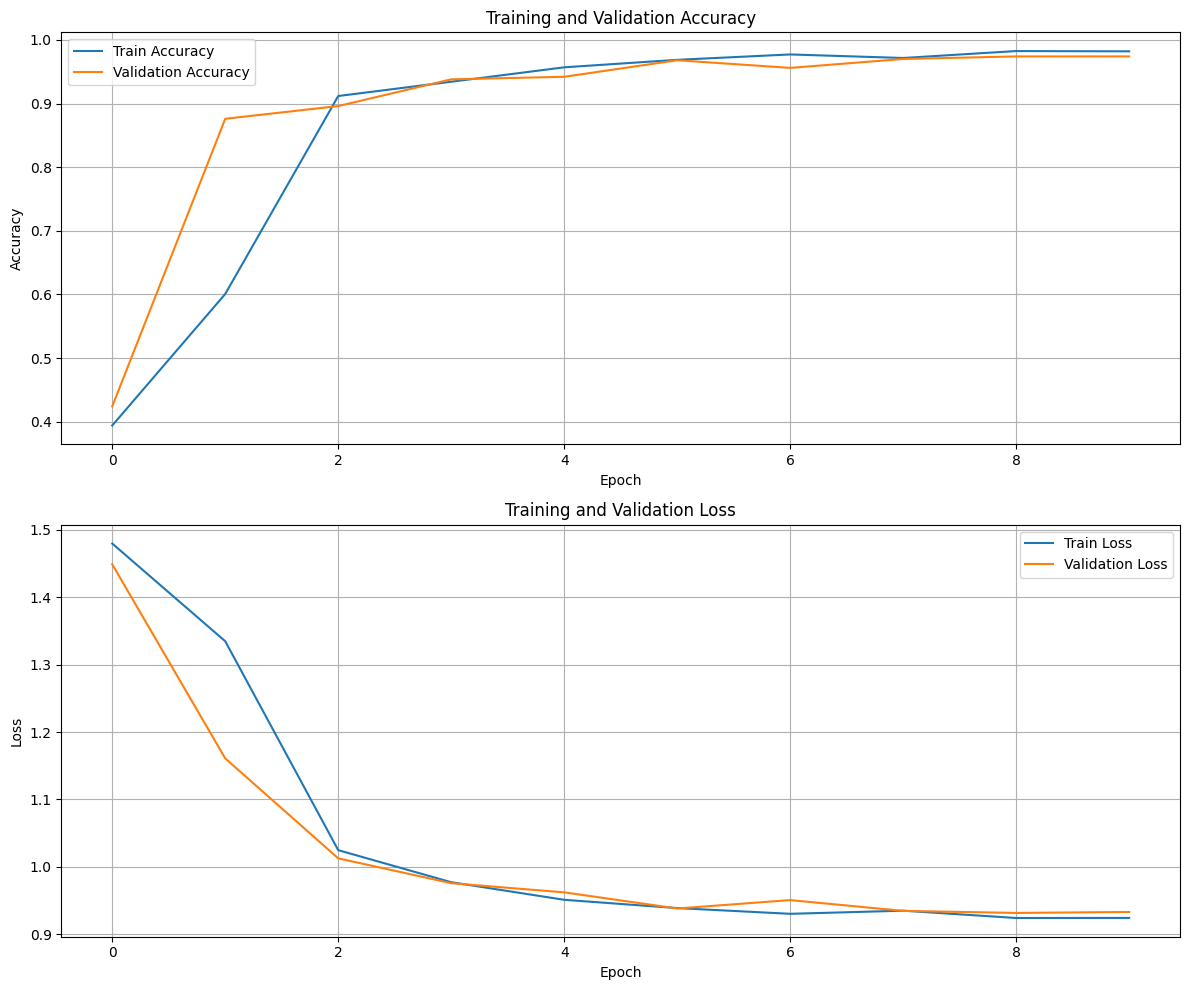

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

logs = pd.read_csv('logs/lightning_logs/version_1/metrics.csv')

train_acc = logs[logs['train_acc'].notna()][['epoch', 'train_acc']]
val_acc = logs[logs['val_acc'].notna()][['epoch', 'val_acc']]
train_loss = logs[logs['train_loss'].notna()][['epoch', 'train_loss']]
val_loss = logs[logs['val_loss'].notna()][['epoch', 'val_loss']]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

ax1.plot(train_acc['epoch'], train_acc['train_acc'], label='Train Accuracy')
ax1.plot(val_acc['epoch'], val_acc['val_acc'], label='Validation Accuracy')
ax1.set_title('Training and Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

ax2.plot(train_loss['epoch'], train_loss['train_loss'], label='Train Loss')
ax2.plot(val_loss['epoch'], val_loss['val_loss'], label='Validation Loss')
ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()

plt.show()

#### Вывод:

как можно видеть из графиков, точность и скорость обучения значительно выросли при применении GRUCell: точность 0.95 на валидации достигается уже к 4-5 эпохам.

#### Задание 2 (8 баллов + 4 бонусных). Генерация антител

Поиграем за B-лимфоцит и попробуем создать новые антитела.

Модель - почти полная копия модели с практики, но есть дополнительное условие: теперь кроме текущего токена и предыдущего скрытого состояния пусть наша ячейка принимает ещё метку биологического вида, к которому должно относиться антитело, вроде такого:

**2.1. (2 балла)** Реализуйте архитектуру модели для генерации антител символ за символом

**2.2. (2 балла)** Обучите модель в течение 10-50 эпох, постройте графики функции ошибки.

**2.3. (4 балла)** Сгенерируйте с помощью модели по 20 антител для каждого биологического вида в отдельных ячейках, выведите их в ноутбуке. Воспользуйтесь функцией `get_sequence_score` (ниже), чтобы посчитать сходство ваших антител с природными (вернее - очень грубую оценку). Посчитайте, сколько антител из сгенерированных вами имеют оценку 0.55 и выше для каждого биологического вида.

**2.4. (Бонус 4 балла)** Повторите пункты 2.2 и 2.3, но используйте другой тип рекуррентной ячейки (GRU или LSTM).


In [ ]:
class ConditionalRNNCell(nn.Module):
    """
    (x_{t}, h_{t-1}, c) -> h_{t}
    """
    def __init__(self, input_dim: int, hidden_dim: int, class_dim: int) -> None:
        super().__init__()
        self.linear = nn.Linear(input_dim + hidden_dim + class_dim, hidden_dim)

    def forward(self, x: torch.Tensor, c: torch.Tensor, h: torch.Tensor) -> torch.Tensor:
        # x: B x input_dim
        # c: B x class_dim
        # h: B x hidden_dim
        combined = torch.cat([x, c, h], dim=1)
        h = self.linear(combined)
        return F.tanh(h)

In [ ]:
class ConditionalRNN(nn.Module):
    def __init__(self, vocab_size: int, hidden_dim: int, class_dim: int, num_classes: int) -> None:
        super().__init__()
        self.embed = nn.Embedding(vocab_size, hidden_dim)
        self.class_embed = nn.Embedding(num_classes, class_dim)
        self.init_h = nn.Parameter(torch.randn(1, hidden_dim))
        self.rnn = ConditionalRNNCell(hidden_dim, hidden_dim, class_dim)
        self.lm_head = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x: torch.Tensor, c: torch.Tensor) -> torch.Tensor:
        # x: B x T
        # c: B x T
        B, T = x.shape

        x = self.embed(x)  # B x T x hidden_dim
        c = c.expand(B, T)
        c = self.class_embed(c)  # B x T x class_dim
        h = self.init_h.expand((B, -1))  # B x hidden_dim

        logits = []  # T x B x V
        for t in range(T):
            xt = x[:, t, :]
            ct = c[:, t, :]
            h = self.rnn(xt, ct, h)  # B x hidden
            y = self.lm_head(h).unsqueeze(1)  # B x 1 x vocab_size
            logits.append(y)

        return torch.cat(logits, dim=1)

In [ ]:
model = ConditionalRNN(vocab_size=len(VOCAB), hidden_dim=64, num_classes=5, class_dim=64)

In [ ]:
train_loader = DataLoader(
    train_dataset, batch_size=32, shuffle=True, collate_fn=dataset.collate_fn
)
test_loader = DataLoader(
    test_dataset, batch_size=32, shuffle=False, collate_fn=dataset.collate_fn
)

In [ ]:
@torch.no_grad()
def generate(model: ConditionalRNN, idx: Tensor, c: Tensor, max_new_tokens: int) -> Tensor:
    # idx: B x T
    for t in range(max_new_tokens):
        logits = model.forward(idx, c)[:, -1]  # B x T x V
        probs = F.softmax(logits, dim=1)  # B x V
        new_token = torch.multinomial(probs, 1)
        idx = torch.cat([idx, new_token], dim=1)

    return idx

In [ ]:
def batch_decode(tensor):
    decode_dict = {
        0: '_', 1: '?', 2: '\n', 3: 'A', 4: 'C', 5: 'D', 6: 'E', 7: 'F', 8: 'G', 9: 'H',
        10: 'I', 11: 'K', 12: 'L', 13: 'M', 14: 'N', 15: 'P', 16: 'Q', 17: 'R', 18: 'S',
        19: 'T', 20: 'V', 21: 'W', 22: 'Y', 23: 'X'
    }

    def decode_sequence(seq):
        decoded = []
        for token in seq:
            if token.item() in {0, 1}:
                continue
            elif token.item() == 2:
                break
            else:
                decoded.append(decode_dict.get(token.item(), '?'))
        return ''.join(decoded)

    decoded_sequences = [decode_sequence(seq) for seq in tensor]

    return decoded_sequences

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
losses = []

for epoch in range(30):
    for tokens, label in train_loader:
        logits = model.forward(tokens, label.view(-1, 1))  # B x T x V
        loss = F.cross_entropy(
            logits[:, :-1].reshape(-1, len(VOCAB)),
            tokens[:, 1:].reshape(-1),
        )
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    losses.append(loss.item())
    print(loss)

tensor(1.8591, grad_fn=<NllLossBackward0>)
tensor(1.4095, grad_fn=<NllLossBackward0>)
tensor(1.3511, grad_fn=<NllLossBackward0>)
tensor(1.2556, grad_fn=<NllLossBackward0>)
tensor(1.0057, grad_fn=<NllLossBackward0>)
tensor(1.1164, grad_fn=<NllLossBackward0>)
tensor(1.0173, grad_fn=<NllLossBackward0>)
tensor(0.9969, grad_fn=<NllLossBackward0>)
tensor(1.0645, grad_fn=<NllLossBackward0>)
tensor(1.1357, grad_fn=<NllLossBackward0>)
tensor(0.9174, grad_fn=<NllLossBackward0>)
tensor(1.0411, grad_fn=<NllLossBackward0>)
tensor(0.9545, grad_fn=<NllLossBackward0>)
tensor(1.0260, grad_fn=<NllLossBackward0>)
tensor(1.1062, grad_fn=<NllLossBackward0>)
tensor(0.8335, grad_fn=<NllLossBackward0>)
tensor(0.9125, grad_fn=<NllLossBackward0>)
tensor(1.0503, grad_fn=<NllLossBackward0>)
tensor(1.0465, grad_fn=<NllLossBackward0>)
tensor(0.9106, grad_fn=<NllLossBackward0>)
tensor(0.8489, grad_fn=<NllLossBackward0>)
tensor(0.9233, grad_fn=<NllLossBackward0>)
tensor(0.9516, grad_fn=<NllLossBackward0>)
tensor(0.84

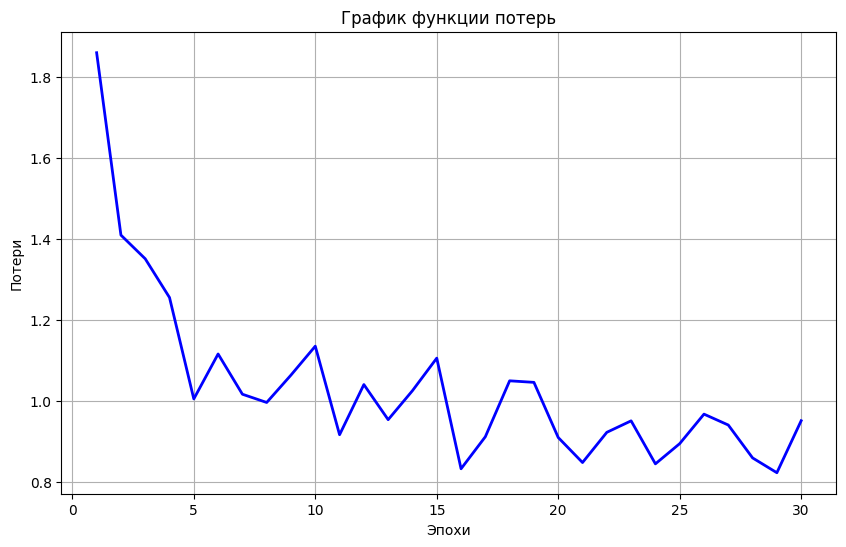

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

epochs = np.arange(1, len(losses) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, losses, 'b-', linewidth=2)
plt.title('График функции потерь')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.grid(True)

plt.show()

In [ ]:
%%capture
! pip install biopython==1.84

In [ ]:
from Bio.Align import PairwiseAligner


def get_sequence_score(query_sequence: str) -> float:
    references = [
        "QVQLQQPGAELVKPGASVKMSCKAS_WITWVKQRPGQGLEWIGDI_TNYNEKFKTKATLTVDTSSSTAYMQLSSLTSEDSAVYYCAR_WGQGTSVTVSS",
        "EVKLEESGGGLVQPGGSMKLSCAAS_WMDWVRQSPEKGLEWVAEI_TYYAESVKGRFTISRDDSKSSVYLQMNSLRAEDTGIYYCTA_WGQGTLVTVSA",
        "HVQLVESGGGSVQPGGSLRLSCTVS_CMGWFRRAPGKEREKVATL_TSYADSVKGRFAISQDPAKNTLWLQMNSLKPEDSATYYCAA_SSRGTQVTVS",
        "QVQLVESGGGSVQAGGSLKLSCAAS_CMGWSRQAPGKGREGVARI_TAYADSVKGRFTISHDSIKNTLYLQMNSLRPEDTAKYYCAA_WGQGTQVTV",
        "QSLEESGGDLVKPGASLTLTCTAS_YMCWVRQAPGKGLEWIACI_TYYASWAKGRFTISKTSSTTVTLQMTSLTAADTATYFCAS_WGQGTLVTVS",
        "QEQLVESGGGLVKPGASLTLTCKAS_VMCWVRQAPGKGLEWIACI_SVYASWAKGRSTISRTSSTTVTLQMTSLTAADTATYFCAR_RGPGTLVTVS",
        "SVKVSCKAS_WIQWVRQAPGQGLEWMGWM_TTYSPKFQGRVSMTSDKSITTAYLELRGLTSDDTAVYSCAR_WGQGTLITVTS",
    ]
    max_score = 0.0
    for ref in map(lambda s: s.replace("_", ""), references):
        alignment = PairwiseAligner().align(query_sequence, ref)[0]
        n_matches = sum(
            1 for i in range(alignment.length) if alignment[0][i] == alignment[1][i]
        )
        max_score = max(max_score, n_matches / len(ref))

    return max_score

In [ ]:
get_sequence_score("HESGGGAVTVSKETLSLTLTYEDTAIYYCAKDDVGGSSYSPVCWLSWGQGTQVTVS")

0.3763440860215054

In [ ]:
get_sequence_score(
    "EVQLVESGGGLVQPGGSLRLSCAASGFTFSDDGMSWVRQAPGKGLEWVAVISSDGSQKSNADSVRDRFTISKDNSKNMLYLQMNNLRLEDTAVYFCTTFSYWGQGVQVTVSS"
)

0.7340425531914894

In [ ]:
samples_all = []

for i in range(5):
    samples = batch_decode(generate(model, idx=torch.full(size=(20, 1), fill_value=1, dtype=int), c=torch.full(size=(20, 1), fill_value=i, dtype=int), max_new_tokens=200))
    samples_all.append(samples)

In [ ]:
types = {0: 'Camel', 1: 'Human', 2: 'Mouse', 3: 'Rabbit', 4: 'Rhesus'}

for i in range(5):
    correct = 0
    for j in range(20):
        if get_sequence_score(samples_all[i][j]) >= 0.55:
            correct += 1
    print(f"Последовательностей с score >= 0.55 для вида {types[i]}: {correct}")

Последовательностей с score >= 0.55 для вида Camel: 10
Последовательностей с score >= 0.55 для вида Human: 15
Последовательностей с score >= 0.55 для вида Mouse: 5
Последовательностей с score >= 0.55 для вида Rabbit: 14
Последовательностей с score >= 0.55 для вида Rhesus: 10


Общая пропорция последовательностей с score >= 0.55: 0.54

#### 2.4

In [ ]:
class ConditionalGRUCell(nn.Module):
    """
    (x_{t}, h_{t-1}, c) -> h_{t}
    """
    def __init__(self, input_dim: int, hidden_dim: int, class_dim: int) -> None:
        super().__init__()
        self.linear_z = nn.Linear(input_dim + hidden_dim + class_dim, hidden_dim)
        self.linear_r = nn.Linear(input_dim + hidden_dim + class_dim, hidden_dim)
        self.linear = nn.Linear(input_dim + hidden_dim + class_dim, hidden_dim)

    def forward(self, x: Tensor, h: Tensor, c:Tensor) -> Tensor:
        # x: B x input_dim
        # c: B x class_dim
        # h: B x hidden_dim
        hс = torch.cat([x, c, h], dim=1)
        zt = torch.sigmoid(self.linear_z(hс))
        rt = torch.sigmoid(self.linear_r(hс))
        h_tilde = torch.tanh(self.linear(torch.cat([x, c, rt * h], dim=1)))
        h = (1 - zt) * h + zt * h_tilde
        return h

In [ ]:
class ConditionalRNN_GRU(nn.Module):
    def __init__(self, vocab_size: int, hidden_dim: int, class_dim: int, num_classes: int) -> None:
        super().__init__()
        self.embed = nn.Embedding(vocab_size, hidden_dim)
        self.class_embed = nn.Embedding(num_classes, class_dim)
        self.init_h = nn.Parameter(torch.randn(1, hidden_dim))
        self.rnn = ConditionalGRUCell(hidden_dim, hidden_dim, class_dim)
        self.lm_head = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x: torch.Tensor, c: torch.Tensor) -> torch.Tensor:
        # x: B x T
        # c: B x T
        B, T = x.shape

        x = self.embed(x)  # B x T x hidden_dim
        c = c.expand(B, T)
        c = self.class_embed(c)  # B x T x class_dim
        h = self.init_h.expand((B, -1))  # B x hidden_dim

        logits = []  # T x B x V
        for t in range(T):
            xt = x[:, t, :]
            ct = c[:, t, :]
            h = self.rnn(xt, ct, h)  # B x hidden
            y = self.lm_head(h).unsqueeze(1)  # B x 1 x vocab_size
            logits.append(y)

        return torch.cat(logits, dim=1)

In [ ]:
model_gru = ConditionalRNN_GRU(vocab_size=len(VOCAB), hidden_dim=64, num_classes=5, class_dim=64)

In [ ]:
train_loader = DataLoader(
    train_dataset, batch_size=32, shuffle=True, collate_fn=dataset.collate_fn
)
test_loader = DataLoader(
    test_dataset, batch_size=32, shuffle=False, collate_fn=dataset.collate_fn
)

In [ ]:
optimizer = torch.optim.Adam(model_gru.parameters(), lr=0.001)

In [ ]:
losses_gru = []

for epoch in range(20):
    for tokens, label in train_loader:
        logits = model_gru.forward(tokens, label.view(-1, 1))  # B x T x V
        loss = F.cross_entropy(
            logits[:, :-1].reshape(-1, len(VOCAB)),
            tokens[:, 1:].reshape(-1),
        )
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    losses_gru.append(loss.item())
    print(loss)

tensor(1.7089, grad_fn=<NllLossBackward0>)
tensor(1.2548, grad_fn=<NllLossBackward0>)
tensor(1.0774, grad_fn=<NllLossBackward0>)
tensor(1.1237, grad_fn=<NllLossBackward0>)
tensor(0.9952, grad_fn=<NllLossBackward0>)
tensor(0.9955, grad_fn=<NllLossBackward0>)
tensor(0.9506, grad_fn=<NllLossBackward0>)
tensor(0.8836, grad_fn=<NllLossBackward0>)
tensor(0.8533, grad_fn=<NllLossBackward0>)
tensor(0.8743, grad_fn=<NllLossBackward0>)
tensor(0.9818, grad_fn=<NllLossBackward0>)
tensor(0.8155, grad_fn=<NllLossBackward0>)
tensor(0.8677, grad_fn=<NllLossBackward0>)
tensor(0.9119, grad_fn=<NllLossBackward0>)
tensor(0.7911, grad_fn=<NllLossBackward0>)
tensor(0.8759, grad_fn=<NllLossBackward0>)
tensor(0.7025, grad_fn=<NllLossBackward0>)
tensor(0.8299, grad_fn=<NllLossBackward0>)
tensor(0.8298, grad_fn=<NllLossBackward0>)
tensor(0.8778, grad_fn=<NllLossBackward0>)


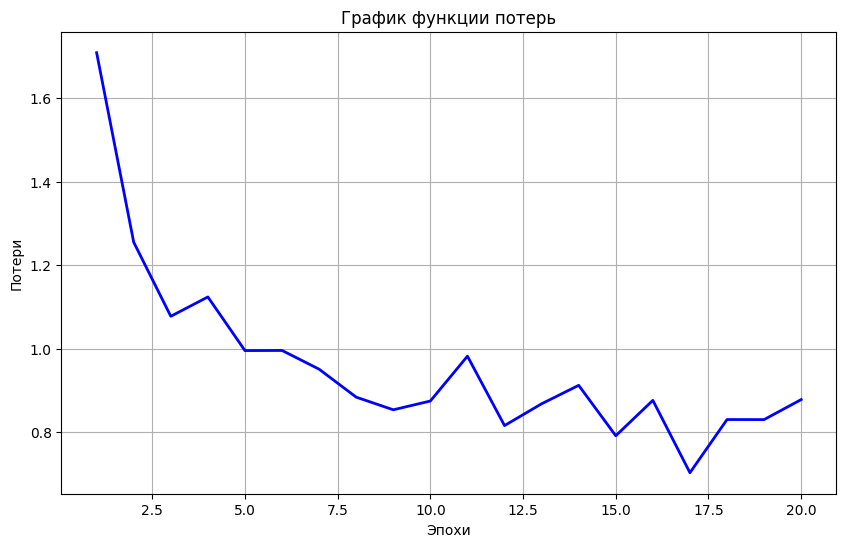

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

epochs = np.arange(1, len(losses_gru) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, losses_gru, 'b-', linewidth=2)
plt.title('График функции потерь')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.grid(True)

plt.show()

In [ ]:
samples_all_gru = []

for i in range(5):
    samples = batch_decode(generate(model_gru, idx=torch.full(size=(20, 1), fill_value=1, dtype=int), c=torch.full(size=(20, 1), fill_value=i, dtype=int), max_new_tokens=200))
    samples_all_gru.append(samples)

In [ ]:
types = {0: 'Camel', 1: 'Human', 2: 'Mouse', 3: 'Rabbit', 4: 'Rhesus'}

for i in range(5):
    correct = 0
    for j in range(20):
        if get_sequence_score(samples_all_gru[i][j]) >= 0.55:
            correct += 1
    print(f"Последовательностей с score >= 0.55 для вида {types[i]}: {correct}")

Последовательностей с score >= 0.55 для вида Camel: 10
Последовательностей с score >= 0.55 для вида Human: 13
Последовательностей с score >= 0.55 для вида Mouse: 15
Последовательностей с score >= 0.55 для вида Rabbit: 12
Последовательностей с score >= 0.55 для вида Rhesus: 11


Общая пропорция последовательностей с score >= 0.55: 0.61